# Customer Retention Analysis: Integrating External Trend Data

To enrich my 'Customer Retention Analysis' project, I will incorporate external data to uncover new insights. Specifically, I aim to identify potential correlations between customer retention trends and public interest in 'e-wallet' topics.

This analysis will involve scraping Google Trends data and integrating it with our existing retention rate data. The analytical pipeline is as follows:

1.  **Scrape Google Trends data:** Extract public interest data for 'e-wallet' related keywords.
2.  **Stransform data using Python:** Combind data from Google trend and our data of transactions to prepare a neat table for visualization
3.  **Store data in Google Cloud Storage:** While the data structure is currently simple, utilizing Google Cloud Storage provides a valuable foundation for leveraging data warehousing capabilities, particularly when dealing with more complex or unstructured data in the future.
4.  **Visualize insights with Looker:** Present trends and correlations over time using Looker.


Let's jump to the first stage of this project

First we need to scape data from Google Trend. But before heading to any scaping, let's have a look at the trend of interest related to 'e-wallet'. 

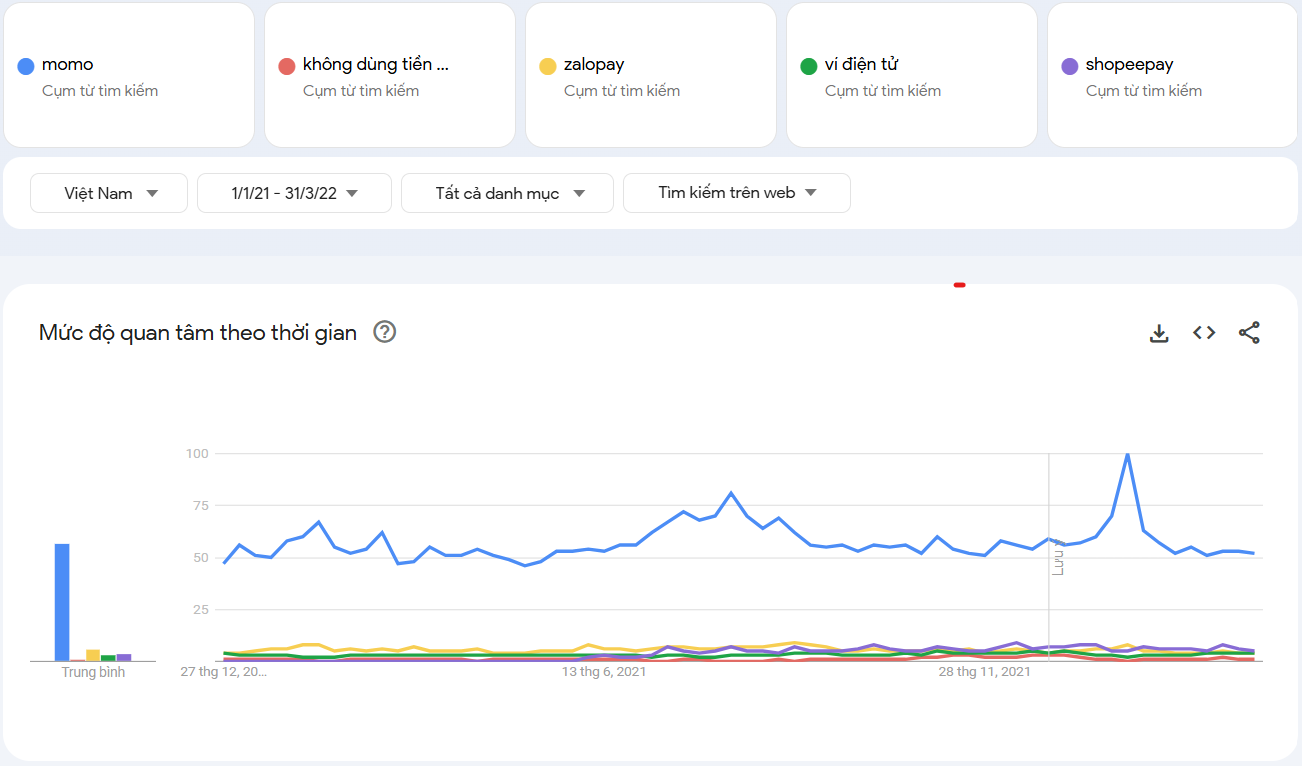

With 5 keywords, we can see that the interest for 'momo' is the dominant one. I will use this data for this keyword to represent for 'e-wallet' topic

## ✅ 1. Scape data from Google Trends
Install the essential packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pytrends.request import TrendReq
pytrends = TrendReq()
import time
import datetime
from datetime import datetime, date, time

Scape data from Google Trend

In [3]:
# Setup pytrends
pytrends = TrendReq(hl='vi-VN', tz=360)
kw_list = ["e-wallet", "momo", "zalopay", "shopeepay", "ví điện tử"]

# Data interest over time
pytrends.build_payload(kw_list, cat=0, timeframe='2021-01-01 2022-03-31', geo='VN')
google_trends = pytrends.interest_over_time().reset_index().drop(columns=['isPartial'])
print(google_trends)

         date  e-wallet  momo  zalopay  shopeepay  ví điện tử
0  2020-12-27         0    47        4          0           4
1  2021-01-03         0    56        4          0           3
2  2021-01-10         0    51        5          0           3
3  2021-01-17         0    50        6          0           3
4  2021-01-24         0    58        6          0           3
..        ...       ...   ...      ...        ...         ...
61 2022-02-27         0    55        4          6           3
62 2022-03-06         0    51        4          5           4
63 2022-03-13         0    53        5          8           4
64 2022-03-20         0    53        4          6           4
65 2022-03-27         0    52        4          5           4

[66 rows x 6 columns]


Convert to CSV file

In [4]:
google_trends.to_csv("google_trends.csv", index=False)

## ✅ 2. Transform scraped data  

In [5]:
transactions = pd.read_csv(r'C:\Users\DELL\OneDrive\Tài liệu\Transactions details.csv', parse_dates=['DATE'])
google_trends = pd.read_csv('google_trends.csv', parse_dates=['date'])

Have a look at the two data tables

In [6]:
transactions.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,Service Group
0,2021-01-01,8733622706,Marketplace,37,61386143,100000,marketplace
1,2021-01-01,8726857991,Supermarket,9,48453125,5000,supermarket
2,2021-01-01,8737326894,Supermarket,9,49921027,106600,supermarket
3,2021-01-01,8732579078,supermarket,9,46022523,270000,supermarket
4,2021-01-01,8725567343,CVS,8,44014594,68000,cvs


In [7]:
google_trends.head()

,date,e-wallet,momo,zalopay,shopeepay,ví điện tử
0,2020-12-27,0,47,4,0,4
1,2021-01-03,0,56,4,0,3
2,2021-01-10,0,51,5,0,3
3,2021-01-17,0,50,6,0,3
4,2021-01-24,0,58,6,0,3


Drop redundant columns

In [8]:
google_trends['trend_score'] = google_trends['momo']
google_trends = google_trends.drop(['e-wallet', 'zalopay', 'momo', 'shopeepay', 'ví điện tử'], axis = 1)
google_trends.head()

,date,trend_score
0,2020-12-27,47
1,2021-01-03,56
2,2021-01-10,51
3,2021-01-17,50
4,2021-01-24,58


Create data including columns for google trend and returned users

In [9]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr


# 1. Create Date column (weekly) to ensure the consistence in time granularity
transactions['week'] = transactions['DATE'] - pd.to_timedelta(transactions['DATE'].dt.weekday + 1, unit='D') + pd.Timedelta(days=7)
transactions['week'] = transactions['week'].dt.normalize()

# 2. Find the first transaction for each user (signup_date) 
first_tx = transactions.groupby('User_id')['DATE'].min().reset_index()
first_tx.columns = ['User_id', 'signup_date']
transactions = transactions.merge(first_tx, on='User_id', how='left')

# 3. Keep transaction made after signup to calculate "retention" 
returned_tx = transactions[transactions['DATE'] > transactions['signup_date']]

# 4. Count the returning users by week
retained_users = (
    returned_tx
    .groupby('week')['User_id']
    .nunique()
    .reset_index()
    .rename(columns={'User_id': 'retained_users'})
)

# 5. Merge with Google Trend data
google_trends['week'] = pd.to_datetime(google_trends['date'])
merged = pd.merge(google_trends, retained_users, on='week', how='left')
merged['retained_users'] = merged['retained_users'].fillna(0)


To check for the lag effect in the return of user, I will create 2 columns for the lag effect of 2 weeks and 3 weeks

In [10]:
merged['trend_score_lag1'] = merged['trend_score'].shift(1)
merged['trend_score_lag2'] = merged['trend_score'].shift(2)

Remember that data from Google trend is relative (the percentage compared with the peak of interest for a specific keyword), we need to normalize/scale for the purpose of consistence in measurement

In [11]:
scaler = MinMaxScaler()
merged[['trend_score_scaled', 'retained_users_scaled']] = scaler.fit_transform(
    merged[['trend_score', 'retained_users']])
    
result = merged[['week', 'trend_score', 'trend_score_lag1', 'trend_score_lag2',
                   'retained_users', 'trend_score_scaled', 'retained_users_scaled']]
result.head()

,week,trend_score,trend_score_lag1,trend_score_lag2,retained_users,trend_score_scaled,retained_users_scaled
0,2020-12-27,47,NaN,NaN,0.0,0.018519,0.000000
1,2021-01-03,56,47.0,NaN,3.0,0.185185,0.004005
2,2021-01-10,51,56.0,47.0,19.0,0.092593,0.025367
3,2021-01-17,50,51.0,56.0,22.0,0.074074,0.029372
4,2021-01-24,58,50.0,51.0,27.0,0.222222,0.036048


Convert to CSV file

In [12]:
result.to_csv("trends_vn.csv", index=False)

## ✅ 3. Upload data to Cloud Storage

In [14]:
from google.cloud import storage
import os
project_id = "customer-retention-analysis"

# Set the environment variable to point to your service account key file
# You would need to upload this file to your Colab environment first
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r'C:\Users\DELL\Downloads\customer-retention-analysis-5ae811411665.json'

# Khởi tạo storage client - it will now use the service account credentials
client = storage.Client(project=project_id)
bucket = client.bucket("data-from-ggtrends")

# Upload file to GCS
blob = bucket.blob("raw/trend_vn.csv")
blob.upload_from_filename("trends_vn.csv")
print("File uploaded successfully.")

File uploaded successfully.


Check for the existence of data in Cloud Storage:

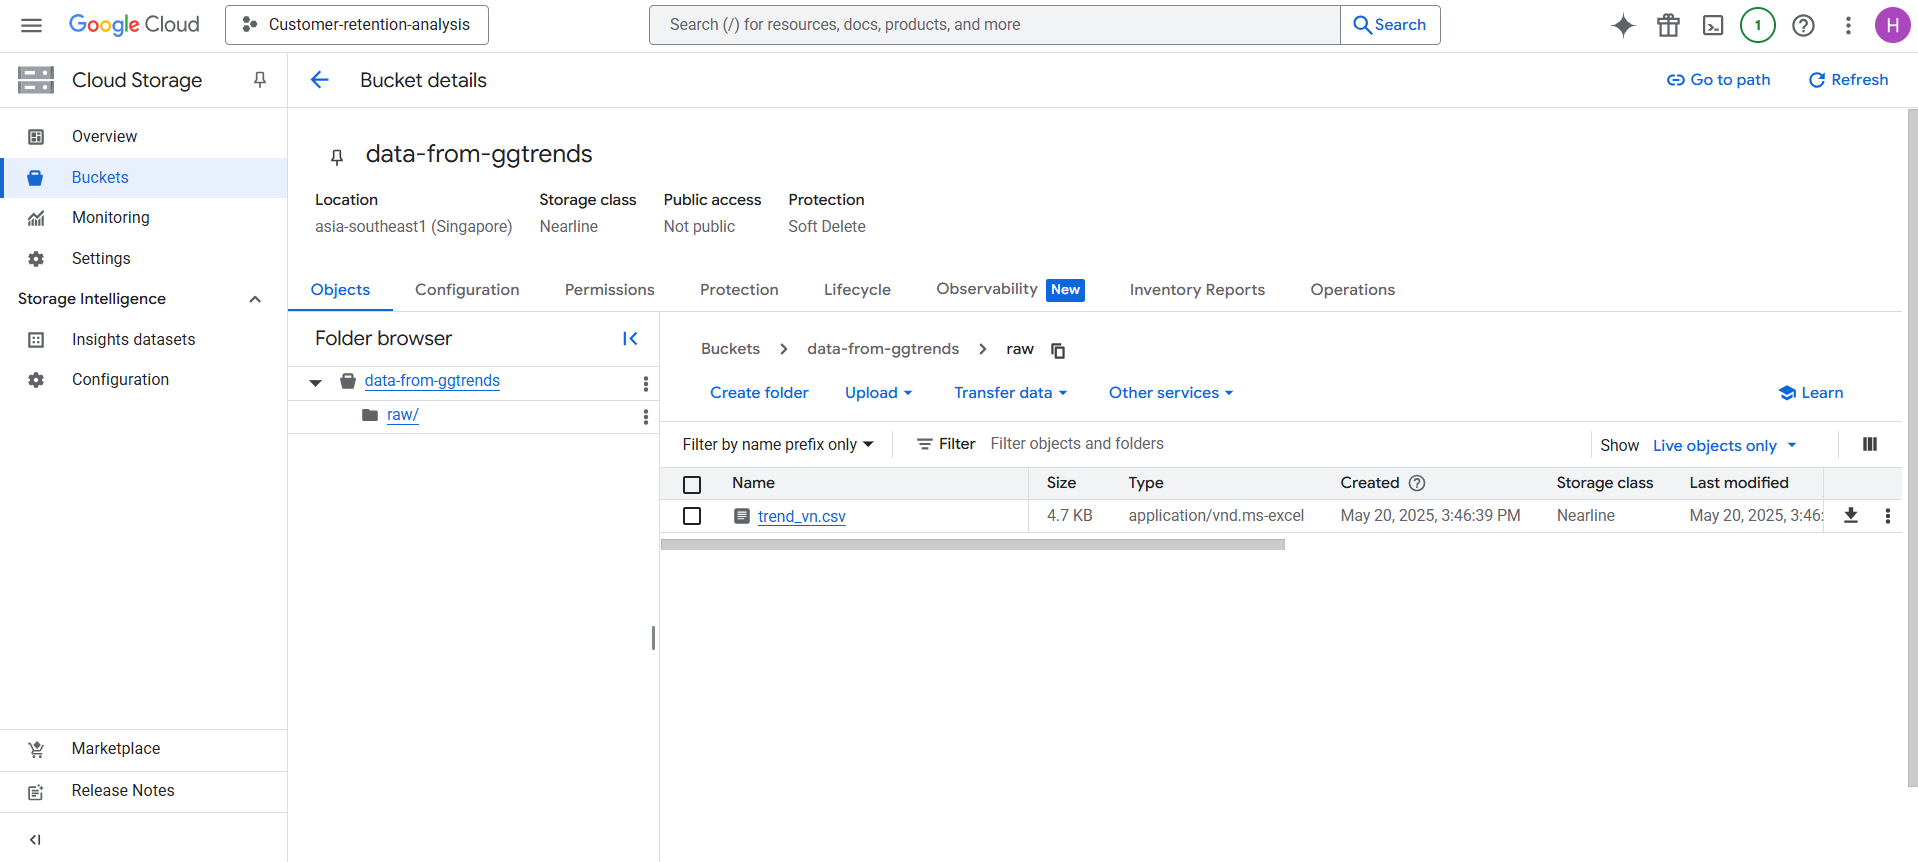

## ✅ 4. Visualize insights with Looker:

Load data to BigQuery:

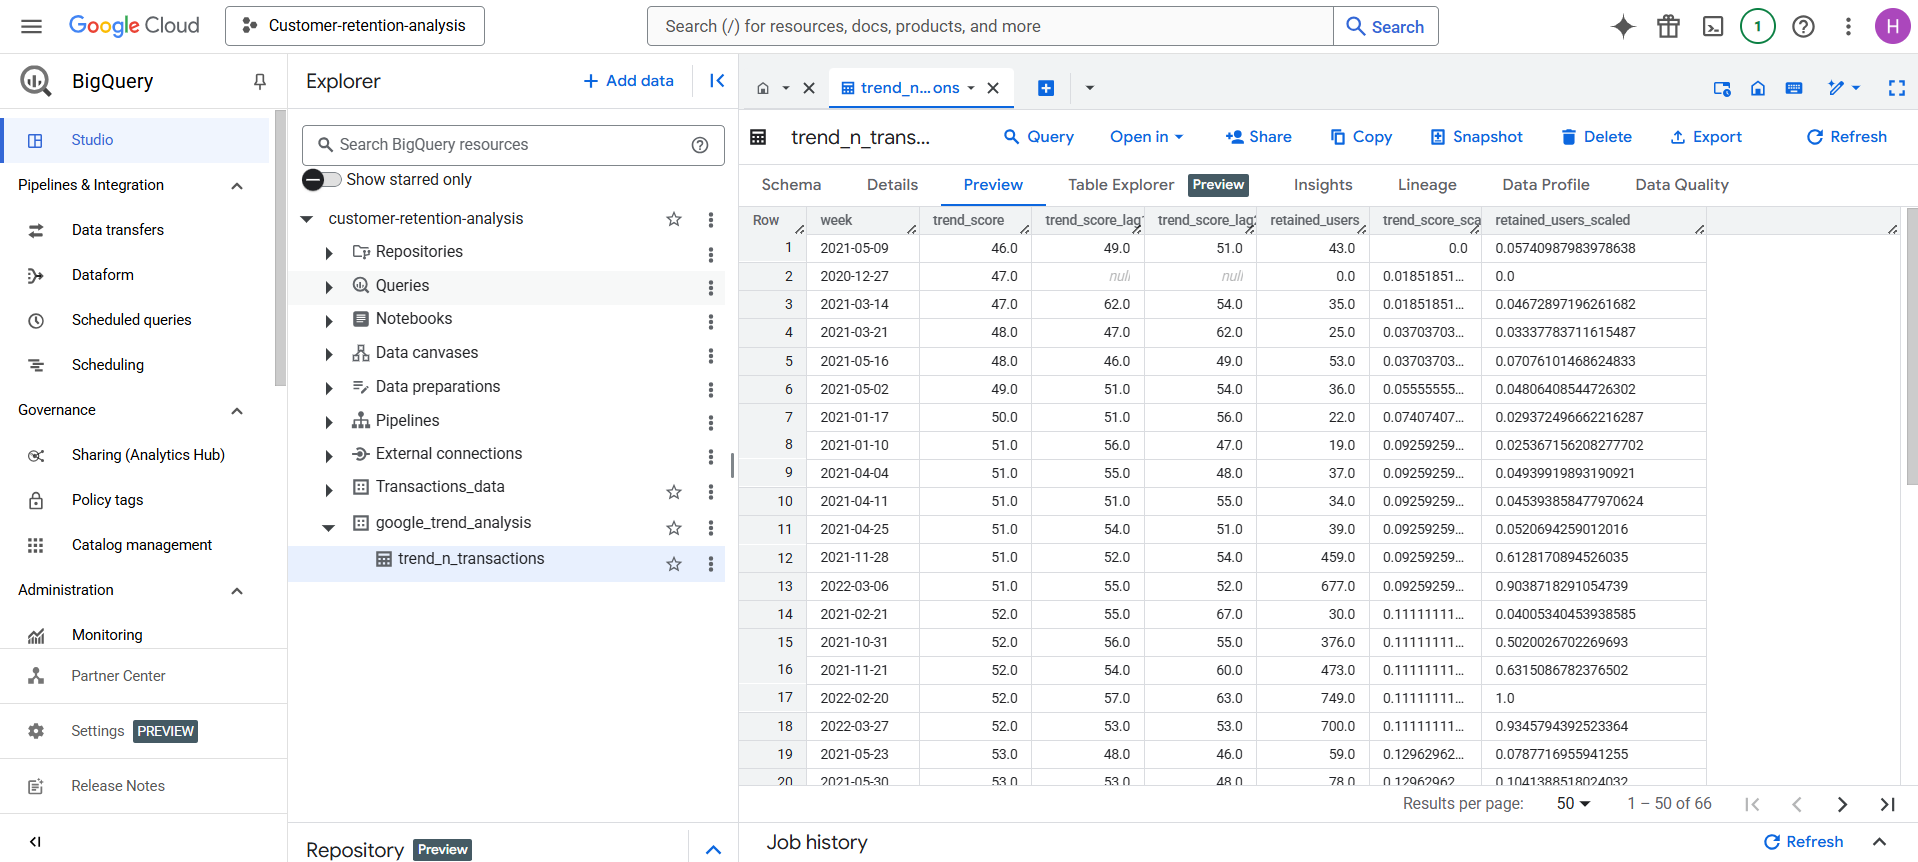

Visualize insights with Looker

https://lookerstudio.google.com/reporting/d13d4401-8336-4711-9826-5464c08dcb0d

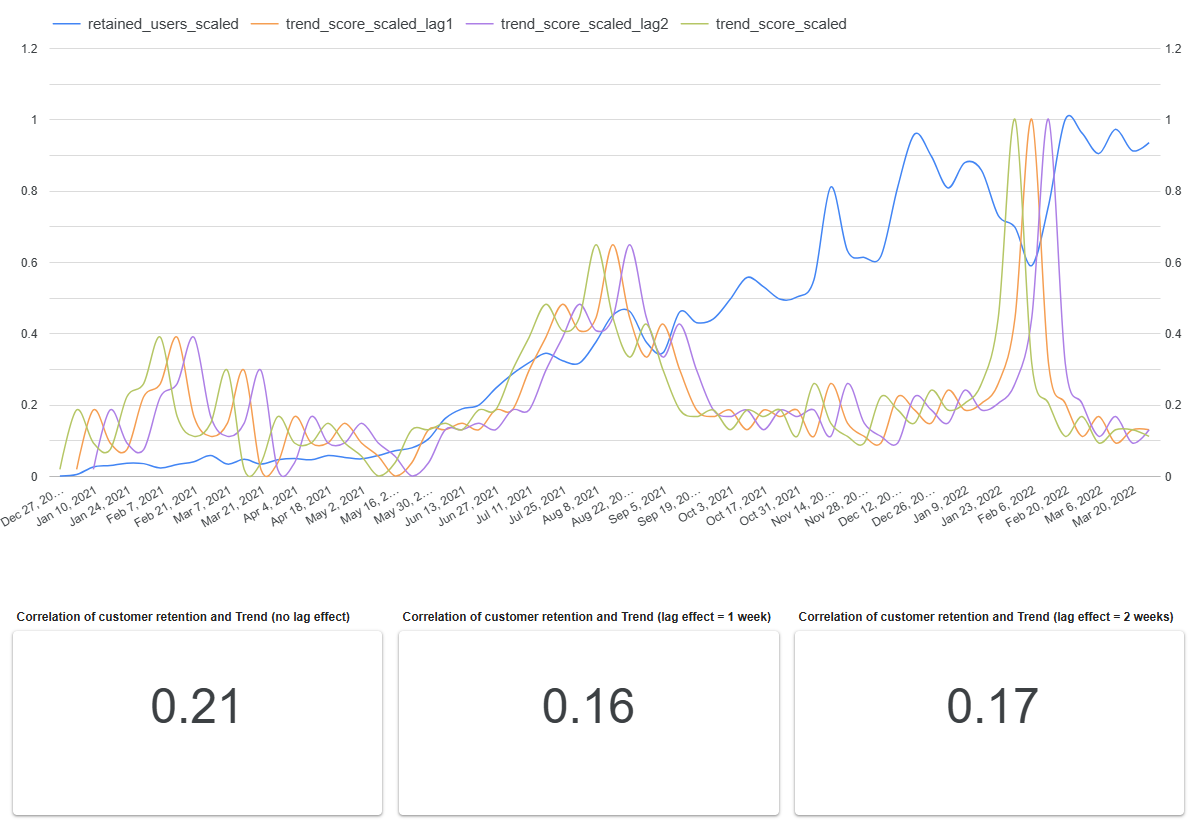

From the chart below, we can see that the interest over time on Google Trend might not be a good prediction for customer retention.